In [1]:
import random
import os
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
import matplotlib
import cv2
import tensorflow as tf
from tensorflow import keras
#import tensorflow_addons as tfa
from tensorflow.keras import mixed_precision
import keras.backend as K

# set the random seed:
RANDOM_SEED = 77
random.seed(RANDOM_SEED)

DATASET_DIR = '/kaggle/input/pastis-dataset-ddp/PASTIS/'

class Singleton(type):
    _instances = {}

    def __call__(cls, *args, **kwargs):
        if cls not in cls._instances:
            cls._instances[cls] = super(Singleton, cls).__call__(*args, **kwargs)
        return cls._instances[cls]

class Metadata(metaclass=Singleton):
    def __init__(self):
        self.dataset_dir = DATASET_DIR
        self._metadata = self._load_metadata_dataframe()
        self._norm_metadata = self._load_norm_metadata()

    @property
    def metadata(self):
        return self._metadata

    @property
    def norm_metadata(self):
        return self._norm_metadata

    def _load_norm_metadata(self):
        return pd.read_json(os.path.join(self.dataset_dir, "NORM_S2_patch.json")).to_dict()

    def _load_metadata_dataframe(self):
        """
        Processing patch metadata and extracting the following features:
        Patch_path, Fold, Patch_id, N_parcel, Parcel_cover, Tile, i_date (date of time series object {i})
        :return: pandas dataframe with metadata of Sentinel-2 patches.
        """
        with open(os.path.join(self.dataset_dir, 'metadata.geojson')) as f:
            metadata = json.load(f)
            metadata = pd.json_normalize(metadata, record_path='features', max_level=1)

        # Processing dates
        dates = pd.DataFrame(metadata['properties.dates-S2'].values.tolist())
        for column in dates.columns:
            d = dates[column]
            dates[f'{column}_date'] = pd.to_datetime(d, format='%Y%m%d')
            dates.drop(columns=[column], inplace=True)

        metadata['Semantic_segmentation_path'] = metadata['properties.ID_PATCH'].apply(lambda x: f'{DATASET_DIR}ANNOTATIONS/TARGET_{x}.npy')
        metadata['Patch_path'] = metadata['properties.ID_PATCH'].apply(lambda x: f'{DATASET_DIR}DATA_S2/S2_{x}.npy')
        metadata.drop(
            columns=['id', 'type', 'properties.id', 'geometry.type', 'geometry.coordinates', 'properties.dates-S2'],
            inplace=True)
        metadata.rename(
            columns={'properties.Fold': 'Fold', 'properties.N_Parcel': 'N_parcel', 'properties.ID_PATCH': 'Patch_id',
                     'properties.Parcel_Cover': 'Parcel_cover', 'properties.TILE': 'Tile'}, inplace=True)

        patches_metadata = pd.concat([metadata, dates], ignore_index=False, axis=1)
        patches_metadata.set_index('Patch_path', inplace=True)

        return patches_metadata

patches_metadata = Metadata().metadata
patches_metadata


2026-01-18 08:48:54.055041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768726134.270209      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768726134.329246      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

,Fold,Patch_id,N_parcel,Parcel_cover,Tile,Semantic_segmentation_path,0_date,1_date,2_date,3_date,...,51_date,52_date,53_date,54_date,55_date,56_date,57_date,58_date,59_date,60_date
Patch_path,,,,,,,,,,,,,,,,,,,,,
/kaggle/input/pastis-dataset-ddp/PASTIS/DATA_S2/S2_10000.npy,1,10000,119,0.808032,t30uxv,/kaggle/input/pastis-dataset-ddp/PASTIS/ANNOTA...,2018-09-24,2018-09-29,2018-10-04,2018-10-09,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
/kaggle/input/pastis-dataset-ddp/PASTIS/DATA_S2/S2_10001.npy,2,10001,111,0.501986,t30uxv,/kaggle/input/pastis-dataset-ddp/PASTIS/ANNOTA...,2018-09-24,2018-09-29,2018-10-04,2018-10-09,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
/kaggle/input/pastis-dataset-ddp/PASTIS/DATA_S2/S2_10002.npy,4,10002,131,0.638722,t30uxv,/kaggle/input/pastis-dataset-ddp/PASTIS/ANNOTA...,2018-09-24,2018-09-29,2018-10-04,2018-10-09,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
/kaggle/input/pastis-dataset-ddp/PASTIS/DATA_S2/S2_10003.npy,5,10003,75,0.866824,t30uxv,/kaggle/input/pastis-dataset-ddp/PASTIS/ANNOTA...,2018-09-24,2018-09-29,2018-10-04,2018-10-09,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
/kaggle/input/pastis-dataset-ddp/PASTIS/DATA_S2/S2_10004.npy,4,10004,46,0.204906,t30uxv,/kaggle/input/pastis-dataset-ddp/PASTIS/ANNOTA...,2018-09-24,2018-09-29,2018-10-04,2018-10-09,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/kaggle/input/pastis-dataset-ddp/PASTIS/DATA_S2/S2_40558.npy,2,40558,33,0.783991,t32ulu,/kaggle/input/pastis-dataset-ddp/PASTIS/ANNOTA...,2018-09-17,2018-09-22,2018-09-27,2018-10-12,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
/kaggle/input/pastis-dataset-ddp/PASTIS/DATA_S2/S2_40559.npy,5,40559,24,0.129896,t32ulu,/kaggle/input/pastis-dataset-ddp/PASTIS/ANNOTA...,2018-09-17,2018-09-22,2018-09-27,2018-10-12,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
/kaggle/input/pastis-dataset-ddp/PASTIS/DATA_S2/S2_40560.npy,3,40560,7,0.255358,t32ulu,/kaggle/input/pastis-dataset-ddp/PASTIS/ANNOTA...,2018-09-17,2018-09-22,2018-09-27,2018-10-12,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [2]:
train_img_list=(list((patches_metadata[patches_metadata['Fold'].isin([1,2,3])].index)))
paths_masks=[]
for path in train_img_list:
    paths_masks.append(patches_metadata.loc[path]['Semantic_segmentation_path'])
train_mask_list = paths_masks

In [3]:
len(train_mask_list)

1455

In [10]:
len(norms['std'])

10

In [12]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import torch.nn as nn
import torch.optim as optim

# 1. Dataset: pixel-wise temporal

class BASTISDatasetTemporal(Dataset):
    def __init__(self, img_files, label_files,
                 crop_size=(64,64),
                 sample_T=38,
                 select_C=list(range(10)),
                 mean=None, std=None):
        self.img_files = img_files
        self.label_files = label_files
        self.crop_size = crop_size
        self.sample_T = sample_T
        self.select_C = select_C
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        data = np.load(self.img_files[idx]).astype(np.float32)  # [T, C, H, W]
        labels = np.load(self.label_files[idx])                 # [T, H, W] or [1, H, W] or [H, W]
        if labels.ndim == 3:
            labels = labels[0]  

        T, C, H, W = data.shape

        # Temporal sampling
        if T >= self.sample_T:
            indices = np.linspace(0, T-1, self.sample_T)
            indices = np.round(indices).astype(int)
            data = data[indices]
        else:
            repeat_times = self.sample_T - T
            data = np.concatenate([data, np.tile(data[-1:], (repeat_times,1,1,1))], axis=0)

        # Channel selection
        data = data[:, self.select_C, :, :]

        # Random crop
        crop_h, crop_w = self.crop_size
        h_start = random.randint(0, H - crop_h) if H > crop_h else 0
        w_start = random.randint(0, W - crop_w) if W > crop_w else 0
        data = data[:, :, h_start:h_start+crop_h, w_start:w_start+crop_w]
        labels = labels[h_start:h_start+crop_h, w_start:w_start+crop_w]

        # Normalize
        data = data / 255.0
        if self.mean is not None and self.std is not None:
            mean = np.array(self.mean).reshape(1, len(self.select_C), 1, 1)
            std = np.array(self.std).reshape(1, len(self.select_C), 1, 1)
            data = (data - mean) / std

        labels = torch.tensor(labels, dtype=torch.long)
        return torch.tensor(data, dtype=torch.float32), labels


# 2. Compute mean / std for normalization

def compute_mean_std(img_files, select_C=list(range(10))):
    mean = np.zeros(len(select_C))
    std = np.zeros(len(select_C))
    n = 0
    print("Calcul des moyennes et écarts-types sur le dataset...")

    for f in img_files:
        data = np.load(f).astype(np.float32)  # [T, C, H, W]
        data = data[:, select_C, :, :] / 255.0
        T, C, H, W = data.shape
        data = data.reshape(T, C, -1)
        mean += data.mean(axis=(0, 2))
        std += data.std(axis=(0, 2))
        n += 1

    mean /= n
    std /= n
    print("Mean:", mean)
    print("Std :", std)
    return mean.tolist(), std.tolist()

# 3. Pixel-wise Temporal Transformer

class PixelTemporalBERT(nn.Module):
    def __init__(self, in_channels=10, emb_size=64, num_heads=4, num_layers=4, max_T=38, dropout=0.1):
        super().__init__()
        self.emb_size = emb_size
        self.pixel_embed = nn.Linear(in_channels, emb_size)
        self.pos_embed = nn.Parameter(torch.randn(1, max_T, emb_size))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_size, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.permute(0, 3, 4, 1, 2)  # [B, H, W, T, C]
        x = x.reshape(B*H*W, T, C)    # each pixel is a sequence
        x = self.pixel_embed(x) + self.pos_embed[:, :T, :]
        x_encoded = self.encoder(x)
        return x_encoded

# 4. Pixel-wise Temporal Classifier

class PixelTemporalClassifier(PixelTemporalBERT):
    def __init__(self, num_classes, pooling='mean', **kwargs):
        super().__init__(**kwargs)
        self.classifier = nn.Linear(self.emb_size, num_classes)
        self.pooling = pooling

    def forward(self, x):
        B, T, C, H, W = x.shape
        x_encoded = super().forward(x)
        if self.pooling == 'mean':
            x_pooled = x_encoded.mean(dim=1)
        else:
            x_pooled = x_encoded[:, -1, :]
        logits = self.classifier(x_pooled)
        logits = logits.reshape(B, H, W, -1).permute(0, 3, 1, 2)
        return logits


# 5. Dataset & Dataloader

train_img_list = train_img_list
train_label_list = train_mask_list

mean, std = compute_mean_std(train_img_list, select_C=list(range(10)))

dataset = BASTISDatasetTemporal(
    train_img_list,
    train_label_list,
    crop_size=(64,64),
    sample_T=38,
    select_C=list(range(10)),
    mean=mean,
    std=std 
)

dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)



# 6. Model, Loss, Optimizer

num_classes = 20
model = PixelTemporalClassifier(
    num_classes=num_classes,
    in_channels=10,
    emb_size=64,
    num_heads=4,
    num_layers=4,
    max_T=38
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()



# 7. Training Loop

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    torch.cuda.empty_cache()

    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        labels = torch.clamp(labels, 0, num_classes-1)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits = model(imgs)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss/len(dataloader):.4f}")


# 8. Save Model

torch.save(model.state_dict(), "pixelbert_temporal_first_label.pth")
print("Model saved successfully!")



# 9. Inference Check

model.eval()
with torch.no_grad(), torch.cuda.amp.autocast():
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = logits.argmax(dim=1)
        print("Prediction shape:", preds.shape)
        break


Calcul des moyennes et écarts-types sur le dataset...
Mean: [ 4.62262548  5.4374227   5.63492118  6.95102648 10.71534805 12.06741702
 12.62595484 13.07718597  9.49563761  6.40198996]
Std : [7.73126573 7.49497136 7.80571224 7.43728218 6.96892076 7.01646258
 7.07645819 7.00428677 5.76226053 5.11949298]


/tmp/ipykernel_47/4152606724.py:170: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_47/4152606724.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/30 | Loss: 1.6163
Epoch 2/30 | Loss: 1.2346
Epoch 3/30 | Loss: 1.1058
Epoch 4/30 | Loss: 1.0269
Epoch 5/30 | Loss: 0.9935
Epoch 6/30 | Loss: 0.9428
Epoch 7/30 | Loss: 0.9130
Epoch 8/30 | Loss: 0.8926
Epoch 9/30 | Loss: 0.8734
Epoch 10/30 | Loss: 0.8660
Epoch 11/30 | Loss: 0.8374
Epoch 12/30 | Loss: 0.8323
Epoch 13/30 | Loss: 0.8142
Epoch 14/30 | Loss: 0.8109
Epoch 15/30 | Loss: 0.8024
Epoch 16/30 | Loss: 0.7935
Epoch 17/30 | Loss: 0.7724
Epoch 18/30 | Loss: 0.7731
Epoch 19/30 | Loss: 0.7715
Epoch 20/30 | Loss: 0.7537
Epoch 21/30 | Loss: 0.7565
Epoch 22/30 | Loss: 0.7458
Epoch 23/30 | Loss: 0.7478
Epoch 24/30 | Loss: 0.7276
Epoch 25/30 | Loss: 0.7309
Epoch 26/30 | Loss: 0.7242
Epoch 27/30 | Loss: 0.7170
Epoch 28/30 | Loss: 0.7128
Epoch 29/30 | Loss: 0.7020
Epoch 30/30 | Loss: 0.7159
Model saved successfully!
Prediction shape: torch.Size([1, 64, 64])


/tmp/ipykernel_47/4152606724.py:209: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


In [29]:
#test dataset 
test_img_list=(list((patches_metadata[patches_metadata['Fold'].isin([5])].index)))
test_paths_masks=[]
for path in test_img_list:
    test_paths_masks.append(patches_metadata.loc[path]['Semantic_segmentation_path'])
test_mask_list = test_paths_masks

In [30]:
#evaluation de modéle : test_dataset
test_dataset = BASTISDatasetTemporal(
    img_files=test_img_list,
    label_files=test_mask_list,
    crop_size=(64, 64),   # ou taille native si possible
    sample_T=38,
    select_C=list(range(10)),
    mean=mean,
    std=std
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)


In [31]:
#Charger le modèle entraîné
model = PixelTemporalClassifier(
    num_classes=20,
    in_channels=10,
    emb_size=64,
    num_heads=4,
    num_layers=4,
    max_T=38
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.load_state_dict(torch.load("pixelbert_temporal_first_label.pth"))
model.to(device)
model.eval()


PixelTemporalClassifier(
  (pixel_embed): Linear(in_features=10, out_features=64, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=64, out_features=20, bias=True)
)

In [33]:
#Évaluation simple : Accuracy pixel-wise
def evaluate_pixel_accuracy(model, dataloader, num_classes):
    correct = 0
    total = 0

    with torch.no_grad(), torch.cuda.amp.autocast():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            labels = torch.clamp(labels, 0, num_classes - 1)

            logits = model(imgs)           # [B, C, H, W]
            preds = logits.argmax(dim=1)   # [B, H, W]

            correct += (preds == labels).sum().item()
            total += labels.numel()

    return correct / total


In [34]:
acc = evaluate_pixel_accuracy(model, test_loader, num_classes=20)
print(f"Pixel Accuracy: {acc:.4f}")


/tmp/ipykernel_47/398982817.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Pixel Accuracy: 0.7531


In [36]:
#Évaluation plus robuste : Mean IoU (mIoU)
def evaluate_miou(model, dataloader, num_classes):
    intersection = torch.zeros(num_classes, device=device)
    union = torch.zeros(num_classes, device=device)

    with torch.no_grad(), torch.cuda.amp.autocast():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            labels = torch.clamp(labels, 0, num_classes - 1)

            preds = model(imgs).argmax(dim=1)

            for cls in range(num_classes):
                pred_i = preds == cls
                label_i = labels == cls

                intersection[cls] += (pred_i & label_i).sum()
                union[cls] += (pred_i | label_i).sum()

    iou = intersection / (union + 1e-6)
    return iou.mean().item(), iou


In [37]:
miou, class_iou = evaluate_miou(model, test_loader, num_classes=20)

print(f"Mean IoU: {miou:.4f}")
for i, iou in enumerate(class_iou):
    print(f"Class {i}: IoU = {iou:.4f}")


/tmp/ipykernel_47/2932297961.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Mean IoU: 0.4936
Class 0: IoU = 0.6545
Class 1: IoU = 0.5982
Class 2: IoU = 0.7816
Class 3: IoU = 0.8014
Class 4: IoU = 0.7161
Class 5: IoU = 0.7997
Class 6: IoU = 0.4513
Class 7: IoU = 0.4904
Class 8: IoU = 0.5054
Class 9: IoU = 0.7995
Class 10: IoU = 0.1469
Class 11: IoU = 0.5131
Class 12: IoU = 0.2520
Class 13: IoU = 0.3939
Class 14: IoU = 0.2720
Class 15: IoU = 0.7450
Class 16: IoU = 0.2366
Class 17: IoU = 0.2464
Class 18: IoU = 0.2239
Class 19: IoU = 0.2437


In [38]:
#Calcul de la matrice de confusion pixel-wise
def compute_confusion_matrix(model, dataloader, num_classes):
    conf_mat = torch.zeros((num_classes, num_classes), dtype=torch.int64)

    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            labels = torch.clamp(labels, 0, num_classes - 1)

            preds = model(imgs).argmax(dim=1)

            preds = preds.view(-1)
            labels = labels.view(-1)

            for t, p in zip(labels, preds):
                conf_mat[t.long(), p.long()] += 1

    return conf_mat


In [39]:
#Calcul OA, AA, Kappa à partir de la matrice
def oa_aa_kappa(conf_mat):
    conf_mat = conf_mat.float()
    num_classes = conf_mat.shape[0]

    # Total pixels
    N = conf_mat.sum()

    # Diagonale
    diag = torch.diag(conf_mat)

    # OA
    OA = diag.sum() / N

    # AA (mean class accuracy)
    class_acc = diag / (conf_mat.sum(dim=1) + 1e-6)
    AA = class_acc.mean()

    # Kappa
    row_sum = conf_mat.sum(dim=1)
    col_sum = conf_mat.sum(dim=0)

    pe = (row_sum * col_sum).sum() / (N * N)
    kappa = (OA - pe) / (1 - pe + 1e-6)

    return OA.item(), AA.item(), kappa.item(), class_acc


In [40]:
#Évaluation complète sur le test set
conf_mat = compute_confusion_matrix(
    model,
    test_loader,
    num_classes=20
)

OA, AA, kappa, class_acc = oa_aa_kappa(conf_mat)

print(f"Overall Accuracy (OA): {OA:.4f}")
print(f"Average Accuracy (AA): {AA:.4f}")
print(f"Kappa: {kappa:.4f}")

for i, acc in enumerate(class_acc):
    print(f"Class {i}: Accuracy = {acc:.4f}")


/tmp/ipykernel_47/3220039099.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Overall Accuracy (OA): 0.7498
Average Accuracy (AA): 0.6143
Kappa: 0.6835
Class 0: Accuracy = 0.7807
Class 1: Accuracy = 0.7969
Class 2: Accuracy = 0.9022
Class 3: Accuracy = 0.9282
Class 4: Accuracy = 0.7669
Class 5: Accuracy = 0.9274
Class 6: Accuracy = 0.4844
Class 7: Accuracy = 0.7242
Class 8: Accuracy = 0.7425
Class 9: Accuracy = 0.9136
Class 10: Accuracy = 0.1749
Class 11: Accuracy = 0.9385
Class 12: Accuracy = 0.4001
Class 13: Accuracy = 0.5410
Class 14: Accuracy = 0.3082
Class 15: Accuracy = 0.7889
Class 16: Accuracy = 0.3505
Class 17: Accuracy = 0.2851
Class 18: Accuracy = 0.2787
Class 19: Accuracy = 0.2536


In [62]:
#Liste de classes
CLASS_NAMES = [
    "Background",
    "Meadow",
    "Soft winter wheat",
    "Corn",
    "Winter barley",
    "Winter rapeseed",
    "Spring barley",
    "Sunflower",
    "Grapevine",
    "Beet",
    "Winter triticale",
    "Winter durum wheat",
    "Fruits, vegetables, flowers",
    "Potatoes",
    "Leguminous fodder",
    "Soybeans",
    "Orchard",
    "Mixed cereal",
    "Sorghum",
    "Void label"
]
NUM_CLASSES = len(CLASS_NAMES)


In [63]:
#Définir les couleurs fixes
import numpy as np
from matplotlib.colors import ListedColormap

CLASS_COLORS = np.array([
    [0, 0, 0],
    [230, 25, 75],
    [60, 180, 75],
    [255, 225, 25],
    [0, 130, 200],
    [245, 130, 48],
    [145, 30, 180],
    [70, 240, 240],
    [240, 50, 230],
    [210, 245, 60],
    [250, 190, 212],
    [0, 128, 128],
    [220, 190, 255],
    [170, 110, 40],
    [255, 250, 200],
    [128, 0, 0],
    [170, 255, 195],
    [128, 128, 0],
    [255, 215, 180],
    [0, 0, 128]
]) / 255.0

cmap = ListedColormap(CLASS_COLORS)


In [64]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def draw_class_legend(ax, class_names, class_colors):
    ax.axis("off")
    ax.set_title("Class Legend", fontsize=12)
    
    for i, name in enumerate(class_names):
        y = 1 - (i + 1) * 0.045
        
        # carré de couleur
        ax.add_patch(Rectangle((0.05, y), 0.08, 0.03, facecolor=class_colors[i], edgecolor="black"))
        
        # texte : ID + nom de classe
        ax.text(0.18, y + 0.015, f"{i} : {name}", fontsize=10, verticalalignment="center")


In [65]:
def visualize_with_legend(imgs, labels, preds, class_names, class_colors, sample_t=0):
    imgs = imgs.cpu()
    labels = labels.cpu()
    preds = preds.cpu()
    
    # RGB image à un timestamp
    rgb = imgs[0, sample_t, :3].permute(1, 2, 0)
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)
    
    fig = plt.figure(figsize=(22, 6))
    gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.9])
    
    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])
    ax2 = fig.add_subplot(gs[2])
    ax3 = fig.add_subplot(gs[3])
    
    ax0.imshow(rgb)
    ax0.set_title("RGB")
    ax0.axis("off")
    
    ax1.imshow(labels[0], cmap=cmap, vmin=0, vmax=NUM_CLASSES-1)
    ax1.set_title("Ground Truth")
    ax1.axis("off")
    
    ax2.imshow(preds[0], cmap=cmap, vmin=0, vmax=NUM_CLASSES-1)
    ax2.set_title("Prediction")
    ax2.axis("off")
    
    draw_class_legend(ax3, class_names, class_colors)
    
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_47/1300819150.py:3: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


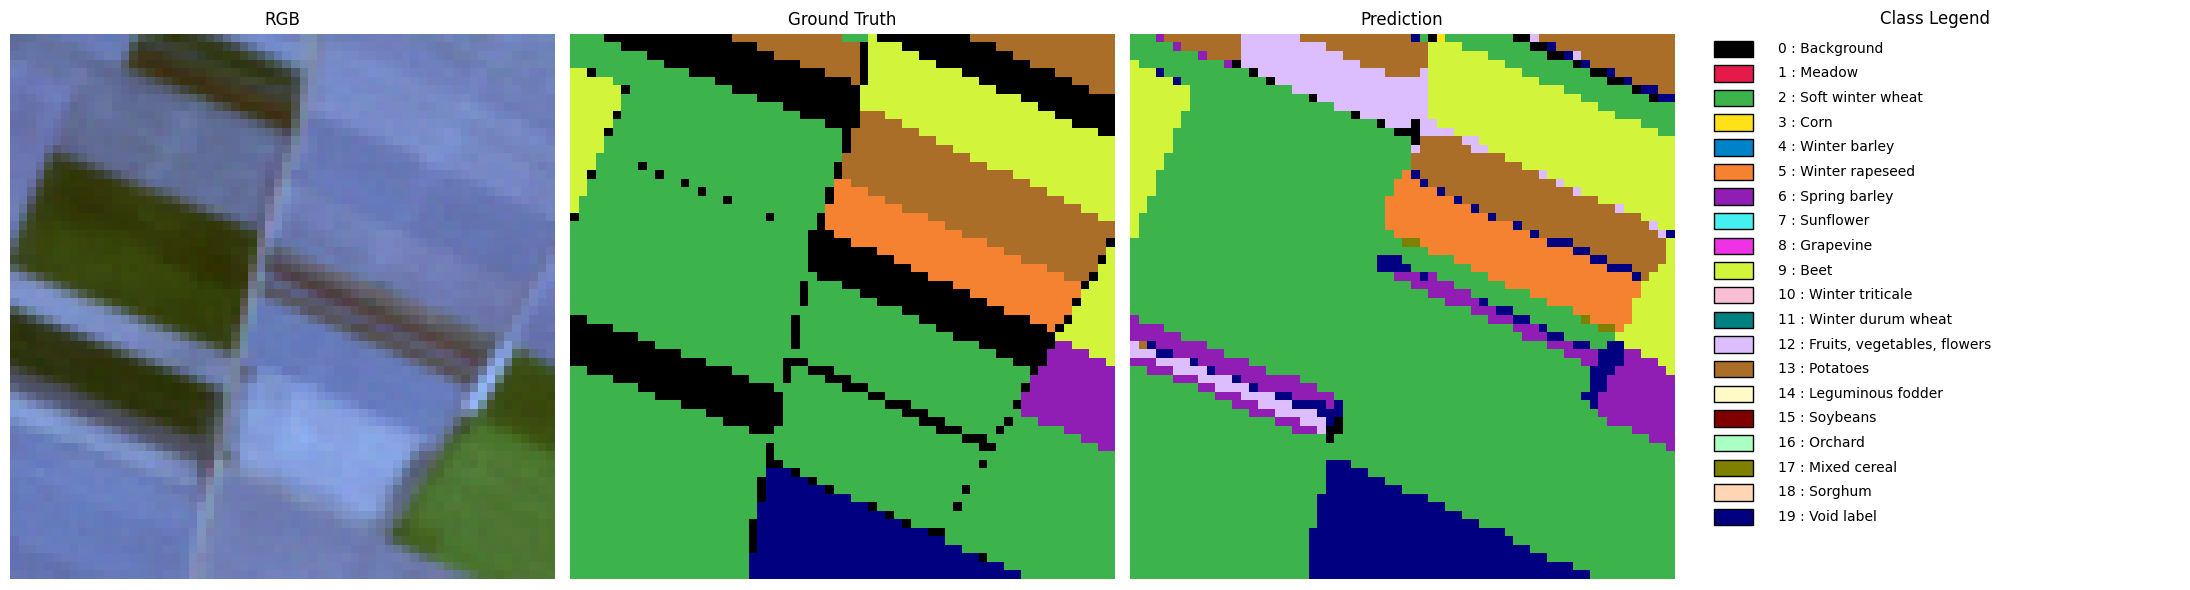

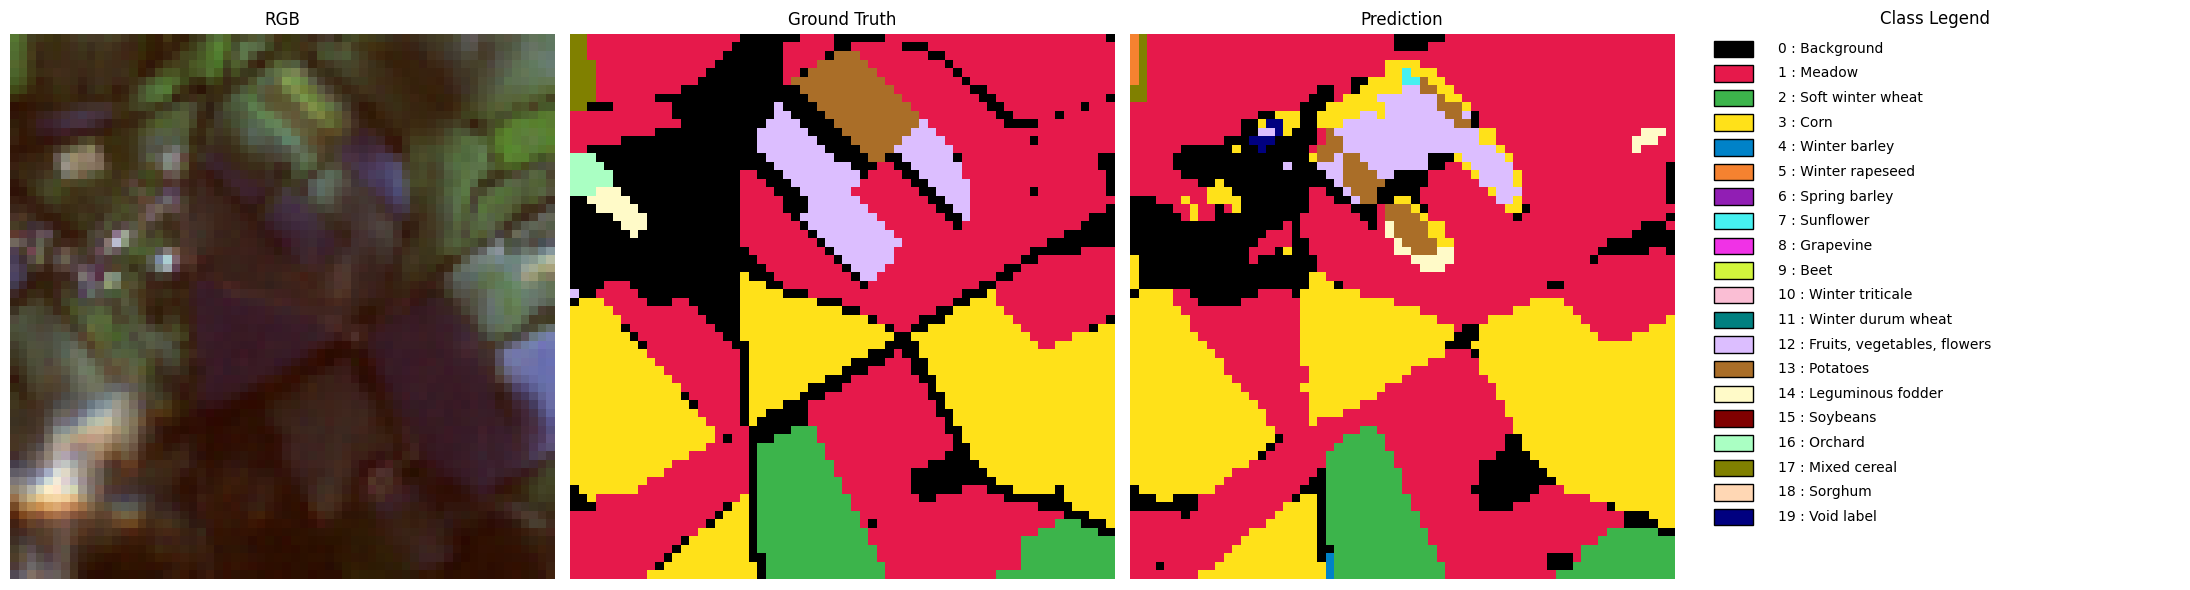

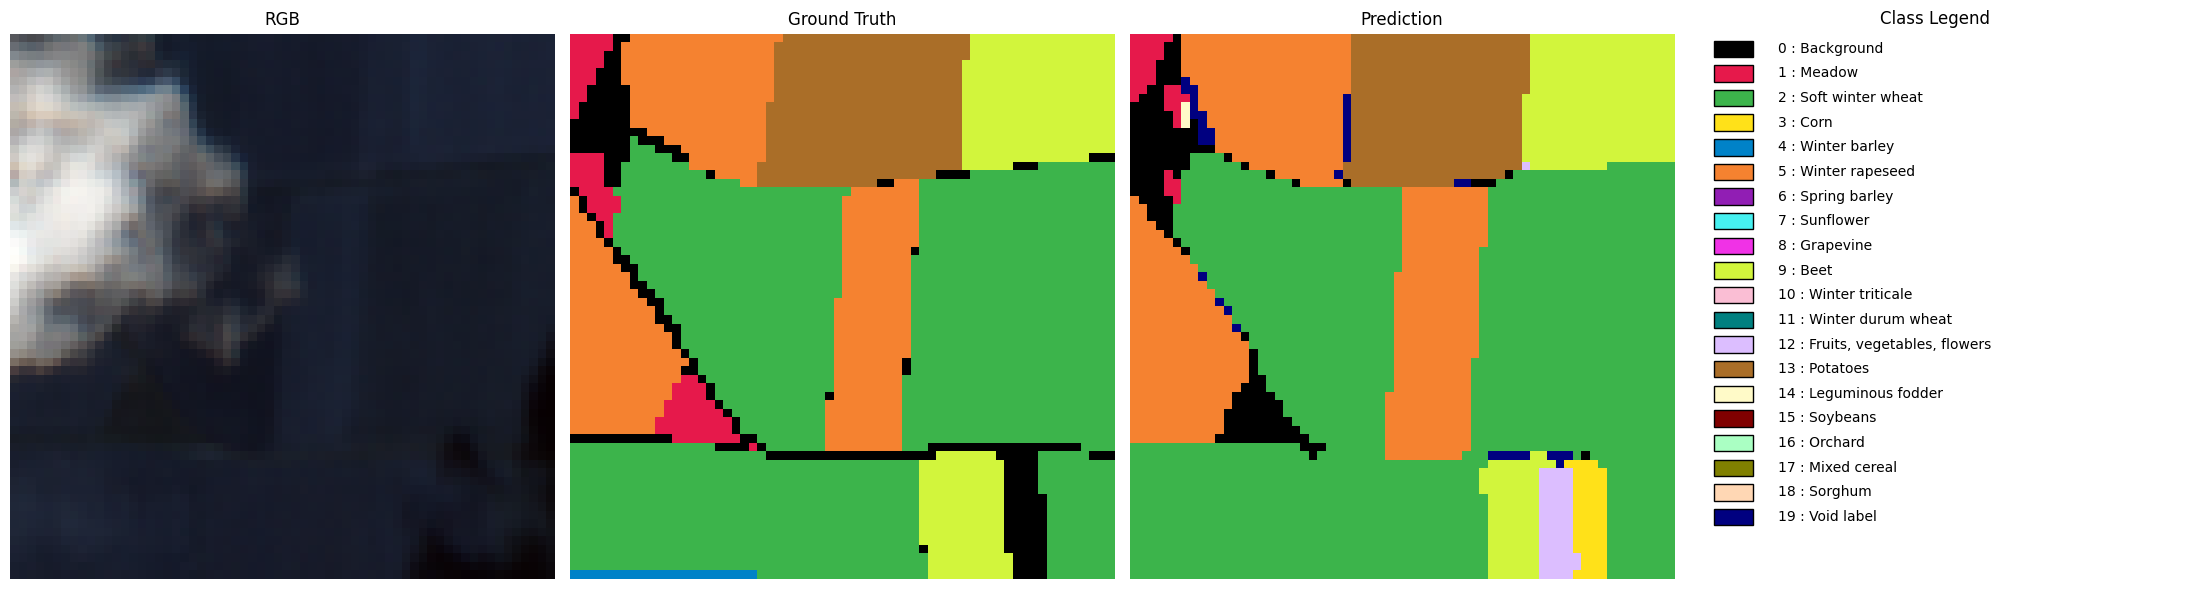

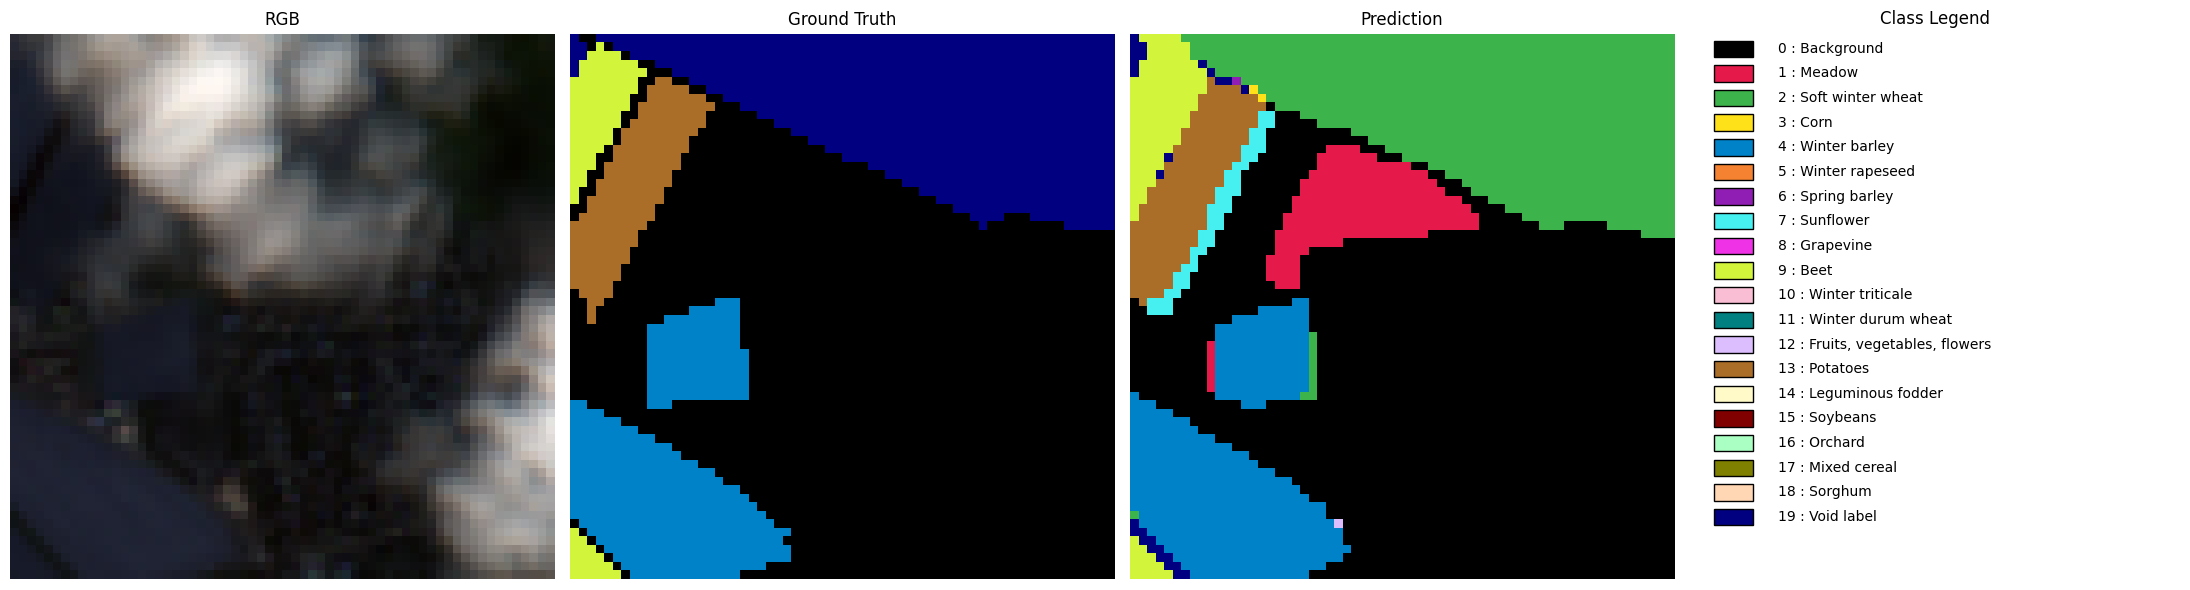

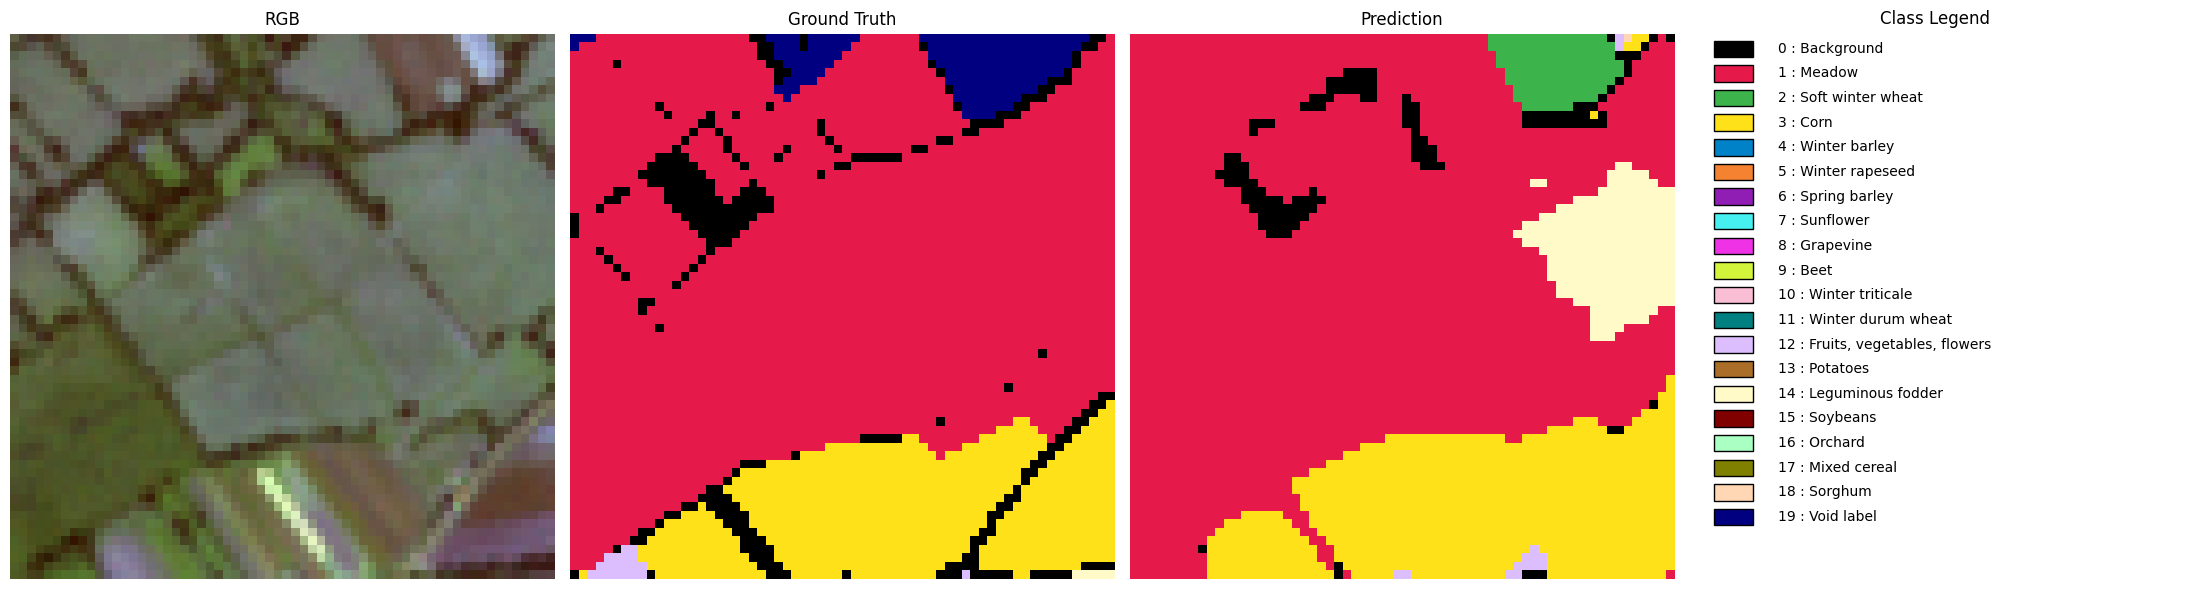

In [66]:
model.eval()

with torch.no_grad(), torch.cuda.amp.autocast():
    for i, (imgs, labels) in enumerate(test_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        preds = model(imgs).argmax(dim=1)
        
        visualize_with_legend(
            imgs, labels, preds,
            class_names=CLASS_NAMES,
            class_colors=CLASS_COLORS,
            sample_t=0
        )

        if i >= 4:  # visualiser 5 images max
            break
